In [1]:
import sys
import os
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Activation,BatchNormalization
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras import callbacks
import pickle
import numpy as np
import cv2

Using TensorFlow backend.


### Dataset Visulization

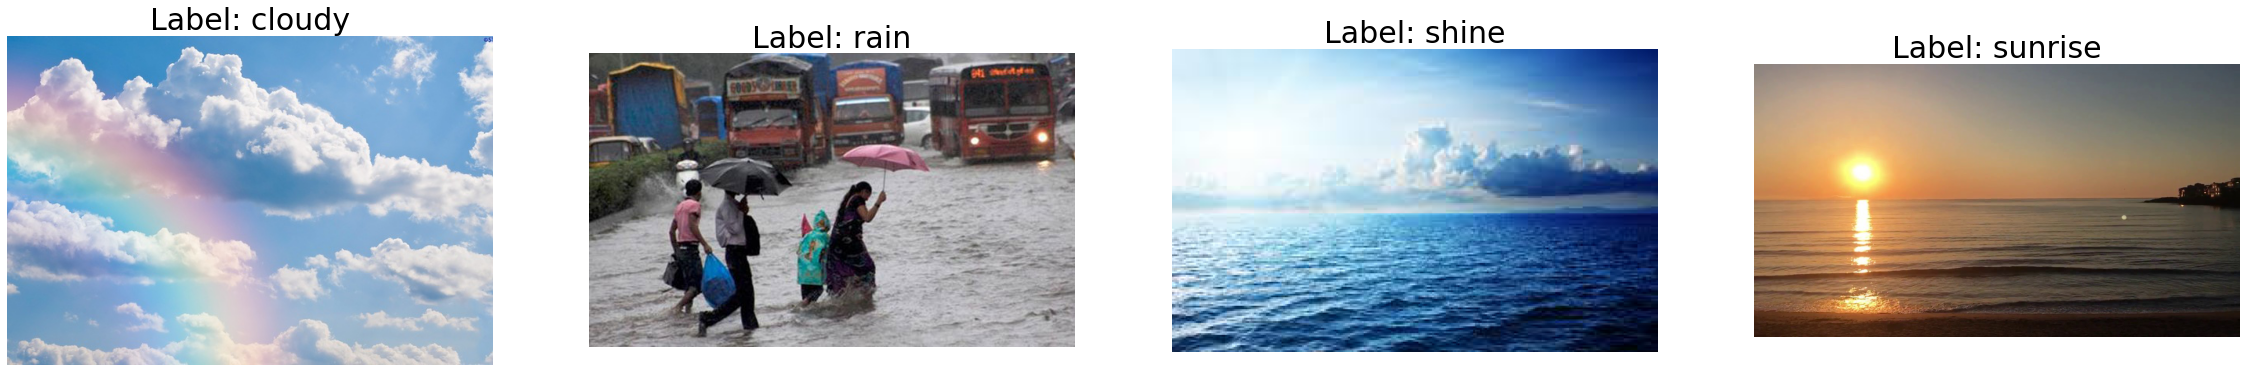

In [17]:
Images=['cloudy/cloudy112.jpg','rain/rain108.jpg','shine/shine12.jpg','sunrise/sunrise114.jpg']
plt.figure(figsize=(40,30))
place_img=0
for i in range(len(Images)):
    
    plt.subplot(1,4,place_img+1)
    plt.imshow(plt.imread('dataset/train/'+Images[i]))
    plt.title('Label: '+Images[i].split('/')[0],fontsize=30)
    plt.axis('off')
    place_img=place_img+1
plt.show()

### Dataset Spliting

In [4]:
## New folder make
Dataset_folder='dataset/'
train_data_path = 'dataset/train/'
test_data_path = 'dataset/test/'

if not os.path.exists(Dataset_folder):
    os.makedirs(Dataset_folder)
if not os.path.exists(train_data_path):
    os.makedirs(train_data_path)
if not os.path.exists(test_data_path):
    os.makedirs(test_data_path)

In [4]:
Test_split=0.2 ## at 20% for test data

Classes=['cloudy', 'rain', 'shine', 'sunrise']
for category in Classes:
    All_images_category=glob.glob('dataset2/'+category+'*') #specific category all images
    np.random.seed(12)
#     print(len(All_images_category))
    np.random.shuffle(All_images_category)
    Train_images=All_images_category[int(len(All_images_category)*Test_split):]
    Test_images=All_images_category[:int(len(All_images_category)*Test_split)]
    print(category,'>     Train Images:',len(Train_images),' Test Images:',len(Test_images))
    train_folder_category=train_data_path+category
    if not os.path.exists(train_folder_category):
        os.makedirs(train_folder_category)# creating new folder of category in the train
    for image_path in Train_images:
        shutil.copy(image_path,os.path.join(train_folder_category,image_path.split('\\')[-1].split('/')[-1]))

    
    test_folder_category=test_data_path+category
    if not os.path.exists(test_folder_category):
        os.makedirs(test_folder_category)# creating new folder of category in the test
    for image_path in Test_images:
        shutil.copy(image_path,os.path.join(test_folder_category,image_path.split('\\')[-1].split('/')[-1]))


cloudy >     Train Images: 240  Test Images: 60
rain >     Train Images: 172  Test Images: 43
shine >     Train Images: 203  Test Images: 50
sunrise >     Train Images: 286  Test Images: 71


## Experimentation:

In [2]:
img_width, img_height = 128,128
batch_size = 2
lr = 0.001

In [5]:

"""
Parameters
"""

train_datagen = ImageDataGenerator(
    rescale=1./ 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(train_data_path,
                                              target_size=(img_width,img_height),
                                              batch_size=batch_size,class_mode='categorical',shuffle = True,seed=1)


test_datagen = ImageDataGenerator(
    rescale=1./ 255)

test_generator = test_datagen.flow_from_directory(test_data_path,
                                             target_size=(img_width,img_height),
                                             batch_size=batch_size,class_mode='categorical',shuffle = False,seed=1)

test_images_count = len(test_generator.filenames)

with open('classes_name.pickle', 'wb') as handle:
    pickle.dump(test_generator.class_indices, handle, protocol=pickle.HIGHEST_PROTOCOL)

Classes=list(test_generator.class_indices.keys())
Classes

Found 901 images belonging to 4 classes.
Found 224 images belonging to 4 classes.


['cloudy', 'rain', 'shine', 'sunrise']

In [6]:
from keras.layers import Input, Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten
from keras.models import Model

def VGG16(Input_shape=(224,224,3),No_classes=4):
    _input = Input(Input_shape) 

    Conv1  = Conv2D(filters=16, kernel_size=(3,3), padding="same", activation="relu")(_input) ## decrease filter number by half
    Conv2  = Conv2D(filters=16, kernel_size=(3,3), padding="same", activation="relu")(Conv1)## decrease filter number by half
    pool1  = MaxPooling2D((2, 2))(Conv2)

    Conv3  = Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu")(pool1)## decrease filter number by half
    Conv4  = Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu")(Conv3)## decrease filter number by half
    pool2  = MaxPooling2D((2, 2))(Conv4)

    Conv5  = Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(pool2)## decrease filter number by half
    Conv6  = Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(Conv5)## decrease filter number by half
    Conv7  = Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(Conv6)## decrease filter number by half
    pool3  = MaxPooling2D((2, 2))(Conv7)

    Conv8  = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(pool3)## decrease filter number by half
    Conv9  = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(Conv8)## decrease filter number by half
    Conv10 = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(Conv9)## decrease filter number by half
    pool4  = MaxPooling2D((4, 4))(Conv10)

    #### Removed these layers###
#     Conv11 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(pool4)
#     Conv12 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(Conv11)
#     Conv13 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(Conv12)
#     pool5  = MaxPooling2D((2, 2))(Conv13)
    #### -------------------###
    
    drop1=Dropout(0.3)(pool4)
    flat   = Flatten()(drop1)
    dense1 = Dense(1024, activation="relu")(flat) # decrease neurons number by half
    drop2=Dropout(0.4)(dense1)
    dense2 = Dense(1024, activation="relu")(drop2)# decrease neurons number by half
    
    output = Dense(No_classes, activation="softmax")(dense2)

    vgg16_model  = Model(inputs=_input, outputs=output)
    return vgg16_model

In [7]:
VGG16_Model=VGG16(Input_shape=(img_width, img_height,3),No_classes=len(Classes))
VGG16_Model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True),
              metrics=['accuracy'])

In [8]:
VGG16_Model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 16)      448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 16)      2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 32)        0   

In [9]:
def get_callbacks_list():
    """Get callbacks for a model"""
    return [callbacks.EarlyStopping(monitor='val_accuracy',patience=25),
            callbacks.ReduceLROnPlateau(verbose=1,monitor='val_loss',factor=0.2,patience=10)]

In [10]:
train_steps = len(train_generator.filenames) // batch_size
test_steps = len(test_generator.filenames) // batch_size
history = VGG16_Model.fit_generator(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=100,
    validation_data=test_generator,
    validation_steps=test_steps,
    callbacks=get_callbacks_list())


Epoch 1/100
450/450 [==============================] - 11s 24ms/step - loss: 1.2893 - accuracy: 0.3560 - val_loss: 0.1913 - val_accuracy: 0.4821
Epoch 2/100
450/450 [==============================] - 10s 22ms/step - loss: 0.9418 - accuracy: 0.5907 - val_loss: 0.0064 - val_accuracy: 0.7054
Epoch 3/100
450/450 [==============================] - 10s 22ms/step - loss: 0.9617 - accuracy: 0.5584 - val_loss: 1.1766 - val_accuracy: 0.4152
Epoch 4/100
450/450 [==============================] - 9s 20ms/step - loss: 1.1855 - accuracy: 0.4449 - val_loss: 0.8767 - val_accuracy: 0.4107
Epoch 5/100
450/450 [==============================] - 10s 22ms/step - loss: 1.0481 - accuracy: 0.5539 - val_loss: 0.1921 - val_accuracy: 0.5000
Epoch 6/100
450/450 [==============================] - 10s 22ms/step - loss: 0.8486 - accuracy: 0.6396 - val_loss: 0.0232 - val_accuracy: 0.6161
Epoch 7/100
450/450 [==============================] - 9s 21ms/step - loss: 0.7138 - accuracy: 0.6963 - val_loss: 0.0310 - val_acc

### Model Save and load

Model is saved and to avoid training time, no need to train from start just load the model then start using it for testing.

In [11]:
VGG16_Model.save('VGG16_Model_upgraded.h5')

In [12]:
# from keras.models import load_model
# VGG16_Model = load_model('VGG16_Model.h5')

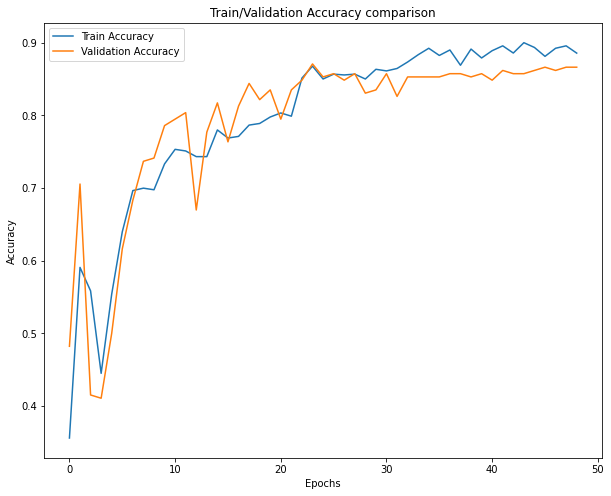

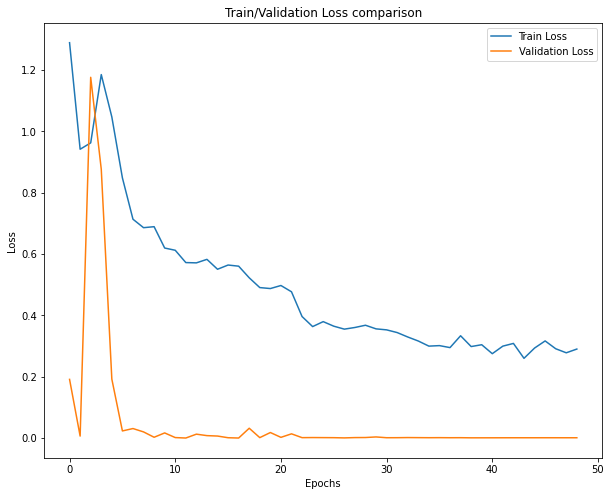

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=[10,8])
plt.plot(history.history['accuracy'],label='Train Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.title('Train/Validation Accuracy comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('Train_Validation_Accuracy_comparison.png')
plt.show()

plt.figure(figsize=[10,8])
plt.plot(history.history['loss'],label='Train Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.title('Train/Validation Loss comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('Train_Validation_Loss_comparison.png')
plt.show()

In [14]:
# test_generator.reset()

from sklearn.metrics import accuracy_score
predicted_labels = VGG16_Model.predict_generator(test_generator,test_steps,workers=1)
accuracy = accuracy_score(test_generator.labels, np.argmax(predicted_labels,axis=1)) * 100
accuracy

86.60714285714286

#### Classification Score and Confusion Metric

In [15]:
from sklearn.metrics import classification_report
print(classification_report(test_generator.labels, np.argmax(predicted_labels,axis=1)))

              precision    recall  f1-score   support

           0       0.82      0.75      0.78        60
           1       0.76      0.79      0.77        43
           2       0.88      0.88      0.88        50
           3       0.96      1.00      0.98        71

    accuracy                           0.87       224
   macro avg       0.85      0.86      0.85       224
weighted avg       0.86      0.87      0.86       224



In [16]:
from sklearn.metrics import confusion_matrix
import pandas as pd
print ("Confusion matrix")
pd.DataFrame(confusion_matrix(test_generator.labels,np.argmax(predicted_labels,axis=1)),columns=Classes,index=Classes)

Confusion matrix


cloudy  rain  shine  sunrise
cloudy       45    10      5        0
rain          8    34      1        0
shine         2     1     44        3
sunrise       0     0      0       71

#### Testing on Image

Predicted Category: sunrise


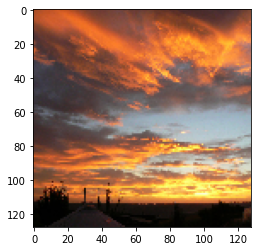

In [18]:
image_test = cv2.imread('dataset/test/sunrise/sunrise10.jpg')
image_test=cv2.cvtColor(image_test,cv2.COLOR_BGR2RGB)
image_test = cv2.resize(image_test,(img_width, img_height))

predicted_category=VGG16_Model.predict([(image_test/255.).reshape(1,img_width, img_height,3)])[0]
predicted_category=np.argmax(predicted_category)

plt.imshow(image_test)
print('Predicted Category:',Classes[predicted_category])

#### Wrong Classification Samples Visulization:

30


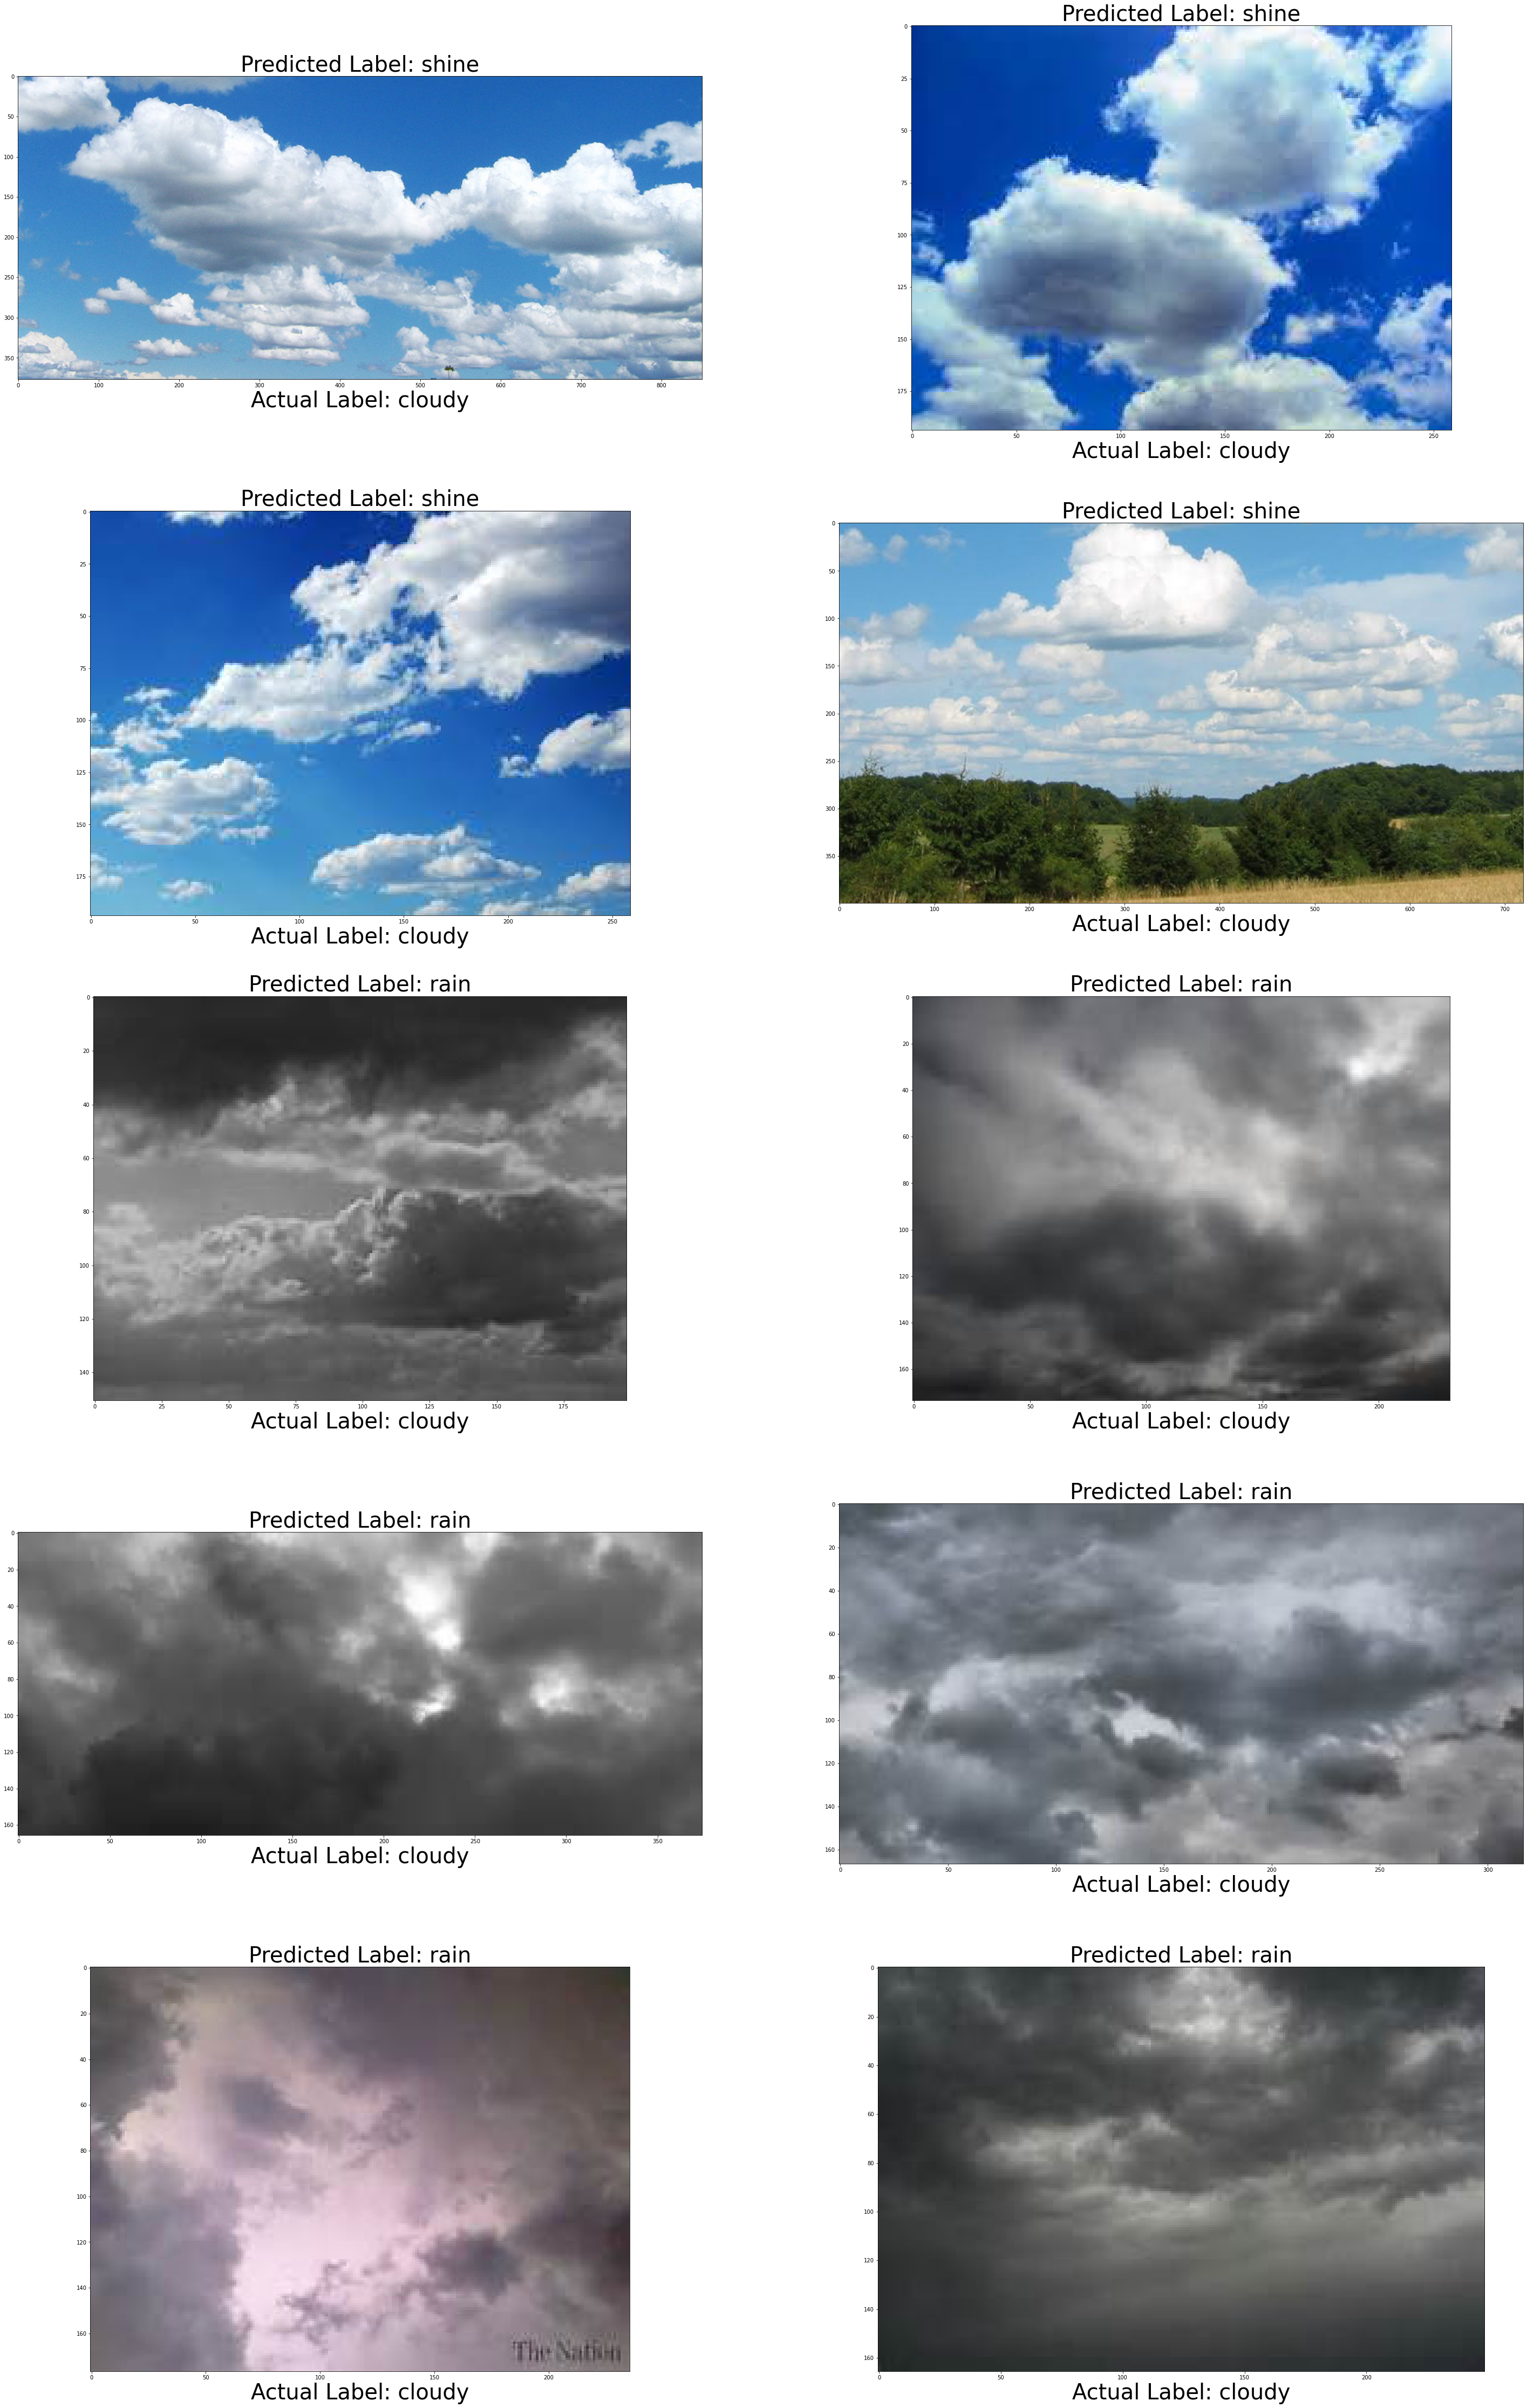

In [21]:
Wrong_classified_Examples=np.where(test_generator.labels!=np.argmax(predicted_labels,axis=1))[0]
print(len(Wrong_classified_Examples))
plt.figure(figsize=(50,80))
place_img=0
predicted_labels_n=np.argmax(predicted_labels,axis=1)
for index in Wrong_classified_Examples[:10]:
    
    plt.subplot(5,2,place_img+1)
    plt.imshow(plt.imread('dataset/test/'+test_generator.filenames[index]))
    plt.title('Predicted Label: '+Classes[predicted_labels_n[index]],fontsize=40)
    plt.xlabel('Actual Label: '+Classes[test_generator.labels[index]],fontsize=40)
#     plt.axis('off')
    place_img=place_img+1
plt.show()